# py4DSTEM Tutorial - Differential Phase Contrast Reconstruction
---

### Introduction

This is a tutorial notebook intended to teach you how to use py4DSTEM to perform a differential phase contrast (DPC) reconstruction from a 4D-STEM dataset. The steps we will perform are:

* [Part 0 - Download and load the 4D-STEM dataset.](#part_00)
* [Part 1 - Calculate the center-of-mass (CoM) for each probe position.](#part_01)
* [Part 2 - Determine the relative rotation between the scan direction and the diffraction space images.](#part_02)
* [Part 3 - Reconstruct the differential phase contrast (DPC) signal.](#part_03)

A deep knowledge of the theory of DPC imaging is not required for this tutorial. All you need to know is that (given some assumptions) when a STEM probe passes through a sample potential, the STEM probe will deflect in the direction of the gradient of this potential. In a far field (diffraction space) measurement, we can directly measure the average momentum change of a STEM probe as a 2-element vector by taking the CoM of the electron counts. We repeat this process for all STEM probe positions. To reconstruct the sample's potential, we simply need to invert this 2D gradient measurement.

For more information on the history and theory of DPC, and the algorithm used in py4DSTEM, see the following references:
* N Dekkers & H De Lang, [Differential phase contrast in a STEM](http://xrm.phys.northwestern.edu/research/pdf_papers/1974/dekkers_optik_1974.pdf), Optik 41, 452–456 (1974).
* A Lubk & J Zweck. [Differential phase contrast: An integral perspective](https://doi.org/10.1103/PhysRevA.91.023805), Phys Rev A 91, 023805 (2015).
* B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)

The 4D-STEM dataset used here is from Hao Yang, Pete Nellist, and collaborators, from this reference:
* Yang, H, Rutte, R, Jones, L, Simson, M, Sagawa, R, Ryll, H, Huth, M, Pennycook, T, Green, M, Soltau, H, Kondo, Y, Davis, BG & Nellist, PD (2016 b). [Simultaneous atomic-resolution electron ptychography and Z-contrast imaging of light and heavy elements in complex nanostructures](https://doi.org/10.1038/ncomms12532) Nature Communications  7, 12532 (2016) 


---
# Part 0 - Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (945 megabytes)
* [Filled Carbon Nanotube](https://drive.google.com/file/d/1bHv3u61Cr-y_GkdWHrJGh1lw2VKmt3UM/view?usp=sharing)

Once you have downloaded this data, update the variable `file_path_input` in the next cell to reflect that path to the file on your computer.

In [1]:
# Initialization - import the needed packages.
# For this tutorial, we will need py4DSTEM, numpy, and h5py
import py4DSTEM
import numpy as np
import h5py    

In [2]:
# Set the file paths for the input datasets.
# The location of these files may be different, depending on your operating system and browser download path.
# If you are running this tutorial on Binder, you do not need to change this path.

# file_data = r'C:\data\4DSTEM\tutorial\carbon_nanotube_data.h5'
file_data = '/media/cophus/DATA/4DSTEM/datasets/carbon_nanotube_data.h5'

In [3]:
# py4DSTEM.io.read(file_data)

In [4]:
# This dataset is stored in an HDF5 file, but is different from the current native py4DSTEM HDF5 / h5 format.

# So, our first step is to list all of the groups inside the .h5 file: (code adapted from issue #406 on the h5py github repo)
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print('%s %s' % (key, val))
        
f = h5py.File(file_data,'r')
f.visititems(print_attrs)

4D-STEM_data
4D-STEM_data/metadata
4D-STEM_data/metadata/calibration
K_pix_size [0.6233536 0.6233536]
K_pix_units b'angstrom^-1'
R_pix_size [0.28 0.28]
R_pix_units b'angstrom'
R_to_K_rotation_degrees 8
4D-STEM_data/metadata/comments
4D-STEM_data/metadata/microscope
accelerating_voltage 80000.0
convergence_semiangle_mrad 26.029473684210526
4D-STEM_data/metadata/original
4D-STEM_data/metadata/original/all
4D-STEM_data/metadata/original/shortlist
4D-STEM_data/metadata/processing
4D-STEM_data/metadata/sample
4D-STEM_data/metadata/user
4DSTEM_experiment
4DSTEM_experiment/data
4DSTEM_experiment/data/datacubes
emd_group_type 1
4DSTEM_experiment/data/datacubes/datacube_0
4DSTEM_experiment/data/datacubes/datacube_0/datacube
4DSTEM_experiment/data/diffractionslices
4DSTEM_experiment/data/pointlistarrays
4DSTEM_experiment/data/pointlists
4DSTEM_experiment/data/realslices


In [5]:
f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['datacube']

<HDF5 dataset "datacube": shape (253, 253, 44, 44), type "<f8">

There are many `groups`, `datasets`, and `attributes` inside this .h5 file. However, we require only one, named:

`4DSTEM_experiment/data/datacubes/datacube_0/datacube`

In [6]:
# The next step is to import this experiment as a py4DSTEM datacube.
# note that we are accessing a "dataset" inside various groups (groups are the HDF5 equivalent of directories)
dataset = py4DSTEM.io.datastructure.DataCube(
    data=f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['datacube']
)

In [7]:
dataset

DataCube( A 4-dimensional array of shape (253, 253, 44, 44) called 'datacube',
          with dimensions:

          Rx = [0,1,...] pixels
          Ry = [0,1,...] pixels
          Qx = [0,1,...] pixels
          Qy = [0,1,...] pixels
)

In [8]:
# Let's examine the mean diffraction space image - first we compute it:
dataset.get_dp_mean();

# note that we can also use this method to return the mean diffraction pattern as a numpy array, by using:
# dp_mean = dataset.get_dp_mean()

# If we don't return a numpy array, we can instead access this image by looking in the "tree" of our dataset:
# dataset.tree['dp_mean'].data

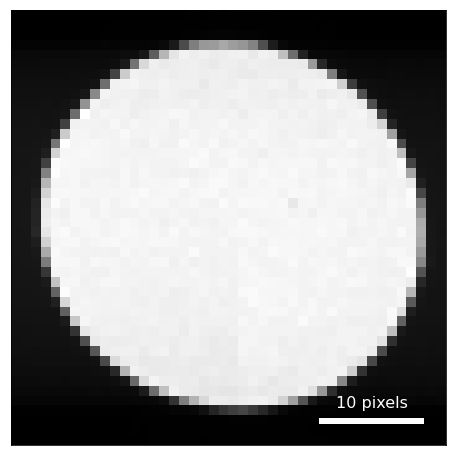

In [9]:
# Plot the mean diffraction pattern
py4DSTEM.visualize.show(
    dataset.tree['dp_mean'],
)

In the mean diffraction pattern image, we can clearly see the initial STEM probe. For a thin specimen, most of the electrons will remain inside the bright field (BF) disk, i.e. the angular range of the initial STEM beam). This means that changing the TEM camera length or cropping the dataset around the BF disk is reasonable, as is the case here.

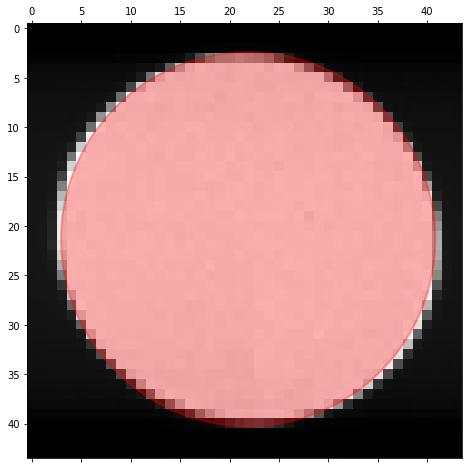

Estimated probe radius = 18.93 pixels


In [10]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(dataset.tree['dp_mean'].data)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    dataset.tree['dp_mean'].data, 
    (probe_qx0, probe_qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

By overlaying a circle, we can see a common artifact in STEM simulations: ellipticity of either the original probe aperture, or the projecter system of the TEM. This ellipticity will not affect our DPC measurement, although we should be careful to use a large enough virtual detector / cropping range to fully capture the BF signal for all probe positions.

In [11]:
# Next, create a bright field (BF) virtual detector using the the center beam position, and expanding the radius slightly (+ 2 px).
center = (probe_qx0, probe_qy0)
radius = probe_semiangle + 2

dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field'
);

100%|██████████████████████████████████████████████████████████████████████████| 64009/64009 [00:01<00:00, 41110.07it/s]


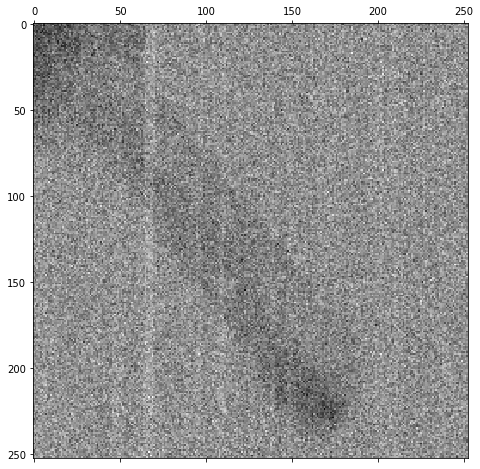

In [12]:
# Plot the bright field image:
py4DSTEM.visualize.show(dataset.tree['bright_field'].data)

Virtually no contrast is visible in the virtual BF image - this image contrast roughly corresponds to the `amplitude` of the sample's exit wave. In the following sections, we will use CoM-DPC to measure the `phase`, which will hopefully produce significantly more signal in the image.

---
# Part 1 - Calculate the center-of-mass (CoM) for each probe position. <a class="anchor" id="part_01"></a>

In this section, we will compute the (qx_shift, qy_shift) momentum vector estimate for all probe positions. We accomplish this by computing the first moment of the intentisty distribution in the x and y directions.

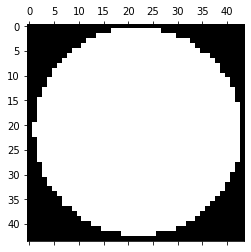

In [13]:
# Make a circular mask slightly larger than the bright field disk
mask = py4DSTEM.process.utils.make_circular_mask(
    dataset.data.shape[2:4],
    (probe_qx0, probe_qy0),
    probe_semiangle + 2.0,
)

# Plot the mask
py4DSTEM.visualize.show(mask, figsize=(4,4))

In [14]:
# Calculate the center of mass for all probe positions, inside the mask
CoMx, CoMy = py4DSTEM.process.dpc.get_CoM_images(dataset, mask=mask)

# Note that in this dataset we could almost certainly skip using the mask, at a small cost to accuracy.

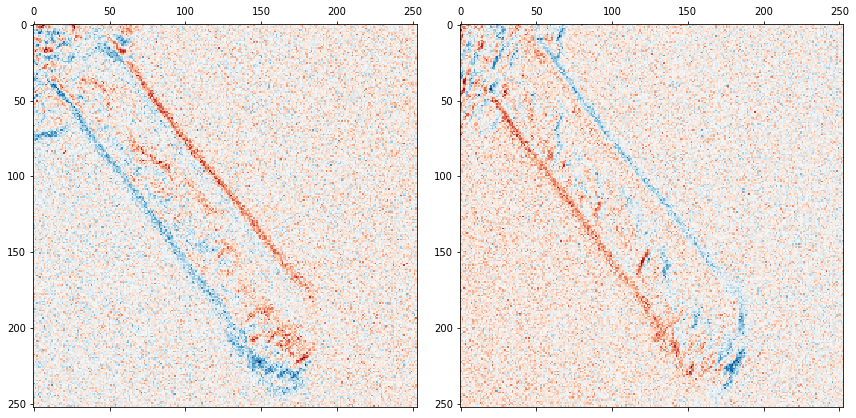

In [15]:
# Plot the 2 CoM outputs, the x and y directions
py4DSTEM.visualize.show_image_grid(
    lambda i:[CoMx, CoMy][i],
    H=1,
    W=2,
    cmap='RdBu')

These images are significantly clearer than the virtual BF image!  

Ideally, CoMx measures the beam deflection in the vertical direction.  As the probe scans downwards, we expect it to deflect in the positive direction (red) as it hits the edge of the sample, and then in the negative direction (blue as it leaves the sample). This is what we observe in the left plot. Similarly, the CoMy signal should show a positive and then negative deflection, as it scans from the left hand edge of the field of view to the right. This is also what we see in the above right side image. 

Therefore, it's likely that the scan directions of this experiment are properly aligned to the diffraction space image coordinates. We will however check this assumption in the next section. We will plot one more output first, the total gradient magnitude sqrt(CoMx^2 + CoMy^2), which is equal to the magnitude of the electric field at each probe position.

/home/cophus/anaconda3/envs/py4DSTEM_dev/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


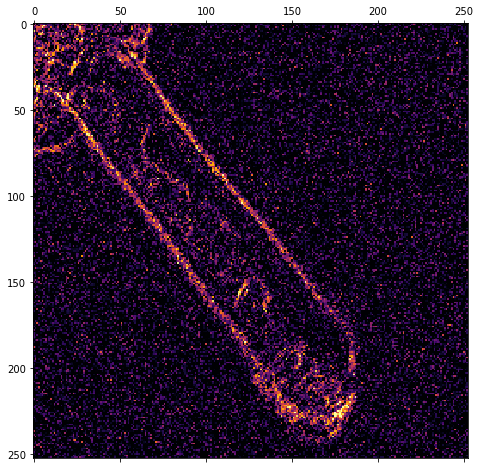

In [16]:
# Plot the gradient magnitude, from 0 to +5 standard deviations
py4DSTEM.visualize.show(
    np.sqrt(CoMx**2 + CoMy**2),
    cmap='inferno',
    clipvals='std',
    min=0.0,
    max=5,
)

---
# Part 2 - Determine the rotation between real and diffraction space. <a class="anchor" id="part_02"></a>

Here, we will check to see if the real space coordinate directions (x,y) matches the diffraction space coordinate directions (qx, qy).  

There are a few methods to perform this check in py4DSTEM.  We will simply test all rotation angles (and all rotation angles for a flipped dataset), and then select whichever angle produces the highest contrast.  Alternative methods include solving for the direction which sets the vector field curl as close to zero as possible, or a gradient search.

In [17]:
# Use one of the py4DSTEM algorithms to check for:
# 1 - rotation offset between real and diffraction space coordinates
# 2 - a flip / transpose of the two spaces
theta, flip =  py4DSTEM.process.dpc.get_rotation_and_flip_maxcontrast(CoMx, CoMy, 360)

100%|█████████████████████████████████████████████████████████████████████████████████| 360/360 [00:10<00:00, 35.71it/s]


In [18]:
# Solve for minimum rotation from (-pi,pi) radian range
theta = np.mod(theta + np.pi, 2*np.pi) - np.pi
theta_deg = theta*180/np.pi

# Print the results
print('Image flip detected =', flip);
print('Best fit rotation = ', '%.4f' % theta_deg, 'degrees')

Image flip detected = False
Best fit rotation =  -12.0334 degrees


As we see, no image flip/transpose was detected. The best fit rotation is -12 degrees, which is within the measurement uncertainty range. 

Additionally, rotations that are significantly less than 45 degrees will not affect the reconstruction very much - DPC is quite robust!

Thus we can proceed with the phase reconstruction.

---
# Part 3 - Reconstruct the phase contrast signal. <a class="anchor" id="part_03"></a>

The final step is to invert the above gradient measurements into the underlying scalar field, the phase shift or potential of the sample.

### Brief description of our phase reconstruction method

The CoM DPC signal measures the gradient of the sample's potential. If we had the potential, we could differentiate it numerically to obtain this gradient. We want to go the other direction however. We could in principle write down the series of linear equations for the center-difference numerical gradient operator, and solve for all of the pixels by inverting this sparse matrix (with some assumptions at the boundaries).  However constructing this matrix is tedious, and it's fairly unstable without regularzation. 

Fortunately, there is a better way! As in most microscopy data analysis problems, we will use Fourier transforms. Essentially, we will compute the "inverse gradient" to reconstruct the DPC phase signal.  For more information, see:
B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

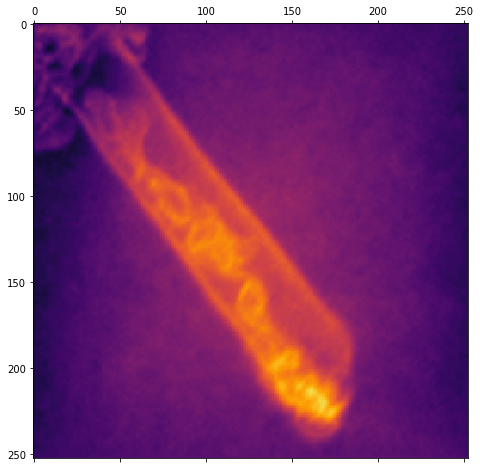

In [19]:
# Input parameters
regLowPass = 0.0
regHighPass = 0.
theta_recon = theta  # We get the same reconstruction with 0 rotation - try it!
flip_recon = flip   # Whether to flip the diffraction coordinates
paddingfactor = 2    # This parameter handles the boundary conditions via padding the reconstruction space
stepsize = 1         # Step size for each iteration
n_iter = 16         # Number of iterations

# Reconstruct the phase
phase, error = py4DSTEM.process.dpc.get_phase_from_CoM(
    CoMx, 
    CoMy, 
    theta=theta_recon, 
    flip=flip_recon,
    regLowPass=regLowPass, 
    regHighPass=regHighPass, 
    paddingfactor=paddingfactor,
    stepsize=stepsize, 
    n_iter=n_iter)

# Plot the output phase image
py4DSTEM.visualize.show(phase,
                       cmap='inferno',
                       clipvals='std',
                       min=-2,
                       max=5)

The nanotube image looks very good!  Even the very weak scattering due to objects inside the nanotube is clearly visible.

However, we can see a long-range error in the lowest spatial frequencies. Out in vacuum, the phase shift should be flat. This is because the condition number worsens for DPC as we approach lower and lower spatial frequencies, eventually reaching the DC phase offset which cannot be measured at all.

For this reason, we often apply a gentle high pass filter, and potentially a low pass filter if the measurement is extremely noisy.  In the next cell, we will re-run the reconstruction with some high pass filtering to regularize the result.

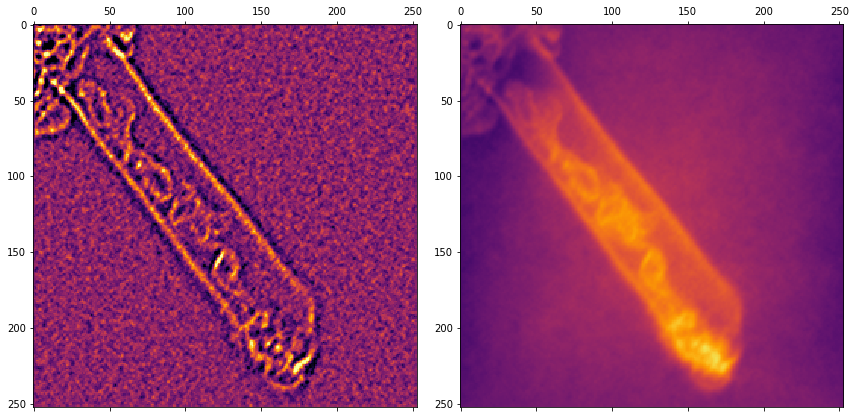

In [20]:
# Input parameters with regularization
regLowPass = 0
regHighPass = 0.005
theta_recon = theta  # We get the same reconstruction with 0 rotation - try it!
flip_recon = flip   # We just set this to False
paddingfactor = 2    # This parameter handles the boundary conditions via padding the reconstruction space
stepsize = 1         # Step size for each iteration
n_iter = 16           # Number of iterations

# Reconstruct the phase
phase_reg, error_ref = py4DSTEM.process.dpc.get_phase_from_CoM(
    CoMx, 
    CoMy, 
    theta=theta_recon, 
    flip=flip_recon,
    regLowPass=regLowPass, 
    regHighPass=regHighPass, 
    paddingfactor=paddingfactor,
    stepsize=stepsize, 
    n_iter=n_iter)

py4DSTEM.visualize.show_image_grid(
    lambda i:[phase_reg, phase][i],
    H=1,
    W=2,
    clipvals='std',
    min=-3,
    max=5,
    cmap='inferno')